In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-20T14:00:41.864211+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl
#import tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
import lightgbm as lgb

from itertools import product
from typing import Tuple

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [6]:
%watermark --iversions

sklearn : 0.24.2
numpy   : 1.20.3
lightgbm: 3.3.2
pandas  : 0.25.3



## Reproducibility block

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [9]:
NTRY = 24
NAME = f'{NTRY}_lgb_pca64_sber_bord_nose_iter_poly'

In [10]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [11]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)

In [12]:
df_train.shape, df_test.shape,

((6981, 338), (3000, 335))

In [13]:
df_train['category'] = df_train['category'].astype('category')
df_test['category']  = df_test['category'].astype('category')

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [15]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend([ 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 #'spec_event_1',
                ])

In [16]:
def r2(preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
    label = data.get_label()
    #weight = data.get_weight()
    #p_dash = (1 - label) + (2 * label - 1) * preds
    #loss_by_example = - np.log(p_dash)
    #loss = np.average(loss_by_example, weights=weight)

    # # eval_name, eval_result, is_higher_better
    return 'r2', r2_score(preds, label), True

In [17]:
def train_lgb_cat(inp_df, inp_vals, inp_category, inp_cat_cols, inp_num_cols):

    
    num_of_leaves_vars    = [4, 8, 16, 32, 64, 128]
    max_depth_vars        = [4, 8, 16, 32]#, 64, 128]
    min_data_in_leaf_vars = [4, 8, 16, 32]#, 64, 128]
    learn_rate_vars       = [0.1, 0.05, 0.01] #1, 0.5, 
    
    min_rmse = 1000000
    ret_progress = []
    
    for nl, lr, md, mdlf in tqdm(product(num_of_leaves_vars, learn_rate_vars, max_depth_vars, min_data_in_leaf_vars), 
                                total = len(num_of_leaves_vars)*len(learn_rate_vars)*len(max_depth_vars)*len(min_data_in_leaf_vars)
                                ):
    
        params = {
            'task': 'train', 
            'boosting': 'gbdt',
            'objective': 'regression',
            'num_leaves': nl,
            'learning_rate': lr,
            'max_depth': md,
            'min_data_in_leaf': mdlf,
            'metric': {'rmse'},
            #'verbose': -1,
            'random_seed': LGB_RANDOMSEED,
            'force_col_wise': False,
            'n_jobs' : -1,
            
            
            #'reg_alpha': 10,   # != 0  Hard L1 regularization
            #'reg_lambda': 0,   # != 0  Hard L2 regularization
        }


        train_ds_views = lgb.Dataset(inp_df[inp_df.category == inp_category][cat_cols + num_cols],
                                     #inp_df[cat_cols + num_cols],
                                     inp_vals[inp_df.category == inp_category][['views']],
                                     #feature_name = [cat_cols + num_cols]
                                    )

        results = lgb.cv(params, 
                         train_ds_views, 
                         num_boost_round = 10000,
                         nfold = 5,
                         verbose_eval = 500,
                         early_stopping_rounds = 100,
                         stratified = False,
                         #return_cvbooster = True,
                        )

        optimal_rounds = np.argmin(results['rmse-mean'])
        best_cv_score  = min(results['rmse-mean'])

        if best_cv_score < min_rmse:
            ret_progress.append(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')
        
        #print(nl, lr, md, mdlf, optimal_rounds, best_cv_score)
        print(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')  
    
    return ret_progress

In [18]:
#views
train_views_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


#depth
train_depth_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )

#full_reads_percent
train_frp_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )

## views

In [19]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 6,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [20]:
%%time
score_v = lgb.cv(params, 
                 train_views_full, 
                 #num_boost_round = 10000,
                 num_boost_round=600,
                 nfold = 5,
                 verbose_eval = 500,
                 #early_stopping_rounds = 100,
                 stratified = False,
                 eval_train_metric = r2,
                 feval = r2,
                 #return_cvbooster = True,
                )
print(np.argmin(score_v['valid rmse-mean']), score_v['train rmse-mean'][np.argmin(score_v['valid rmse-mean'])], score_v['train rmse-stdv'][np.argmin(score_v['valid rmse-mean'])], )
print(np.argmin(score_v['valid rmse-mean']), score_v['valid rmse-mean'][np.argmin(score_v['valid rmse-mean'])], score_v['valid rmse-stdv'][np.argmin(score_v['valid rmse-mean'])], )

print(np.argmax(score_v['valid r2-mean']), score_v['train r2-mean'][np.argmax(score_v['valid r2-mean'])], score_v['train r2-stdv'][np.argmax(score_v['valid r2-mean'])], )
print(np.argmax(score_v['valid r2-mean']), score_v['valid r2-mean'][np.argmax(score_v['valid r2-mean'])], score_v['valid r2-stdv'][np.argmax(score_v['valid r2-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 6495.79 + 2592.21	cv_agg's train r2: 0.985868 + 0.00757978	cv_agg's valid rmse: 39577 + 13623.1	cv_agg's valid r2: 0.0980698 + 0.583558
129 18590.861927983628 4988.937186361862
129 39493.82728758491 13687.446354448335
301 0.9565275654729255 0.020607193249939957
301 0.09879796293785362 0.5886444330778817
Wall time: 34.1 s


In [21]:
#score_v.keys()

In [22]:
#if np.argmin(score_v['valid rmse-mean']) != np.argmax(score_v['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_v['valid rmse-mean']), np.argmax(score_v['valid r2-mean']))

In [23]:
#views_iter = np.argmax(score_v['valid r2-mean'])
views_iter = np.argmin(score_v['valid rmse-mean'])
print(views_iter)

129


In [24]:
lgb_model_views = lgb.train(params,
                            train_set=train_views_full,
                            num_boost_round = views_iter,
                            #early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

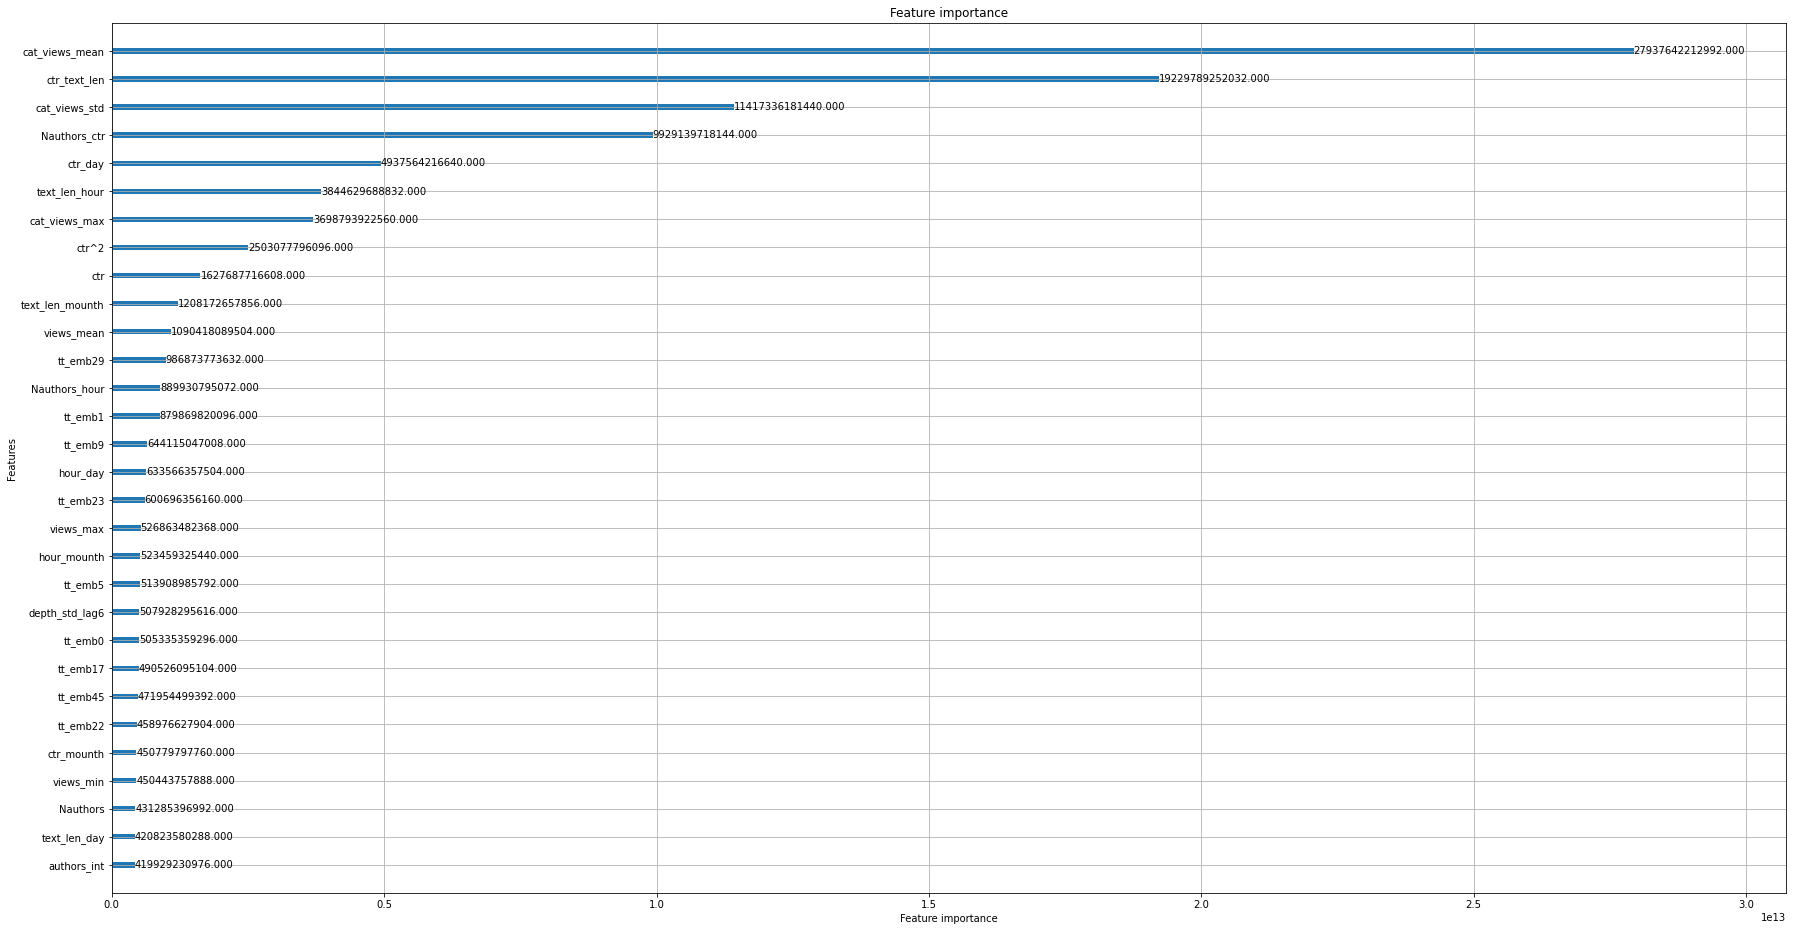

In [25]:
lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

## depth

In [26]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [45]:
%%time
score_d = lgb.cv(params, 
                 train_depth_full, 
                 #num_boost_round = 10000,
                 num_boost_round=600,
                 nfold = 5,
                 verbose_eval = 500,
                 #early_stopping_rounds = 100,
                 stratified = False,
                 eval_train_metric = r2,
                 feval = r2,
                 #return_cvbooster = True,
                )
print(np.argmin(score_d['valid rmse-mean']), score_d['train rmse-mean'][np.argmin(score_d['valid rmse-mean'])], score_d['train rmse-stdv'][np.argmin(score_d['valid rmse-mean'])], )
print(np.argmin(score_d['valid rmse-mean']), score_d['valid rmse-mean'][np.argmin(score_d['valid rmse-mean'])], score_d['valid rmse-stdv'][np.argmin(score_d['valid rmse-mean'])], )

print(np.argmax(score_d['valid r2-mean']), score_d['train r2-mean'][np.argmax(score_d['valid r2-mean'])], score_d['train r2-stdv'][np.argmax(score_d['valid r2-mean'])], )
print(np.argmax(score_d['valid r2-mean']), score_d['valid r2-mean'][np.argmax(score_d['valid r2-mean'])], score_d['valid r2-stdv'][np.argmax(score_d['valid r2-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.00222324 + 0.000186827	cv_agg's train r2: 0.998671 + 0.000244977	cv_agg's valid rmse: 0.0259152 + 0.00135199	cv_agg's valid r2: 0.792205 + 0.0147515
86 0.013566547878928558 0.00023073944193315713
86 0.025893598134834876 0.0013144564666354988
599 0.9993650326690225 0.00017320709414835161
599 0.7923991866632294 0.01470467440666319
Wall time: 55.3 s


In [28]:
#if np.argmin(score_d['valid rmse-mean']) != np.argmax(score_d['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_d['valid rmse-mean']), np.argmax(score_d['valid r2-mean']))

In [29]:
#depth_iter = np.argmax(score_d['valid r2-mean'])
depth_iter = np.argmin(score_d['valid rmse-mean'])
print(depth_iter)

86


In [30]:
# fitting the model
lgb_model_depth = lgb.train(params,
                            train_set=train_depth_full,
                            num_boost_round = depth_iter,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

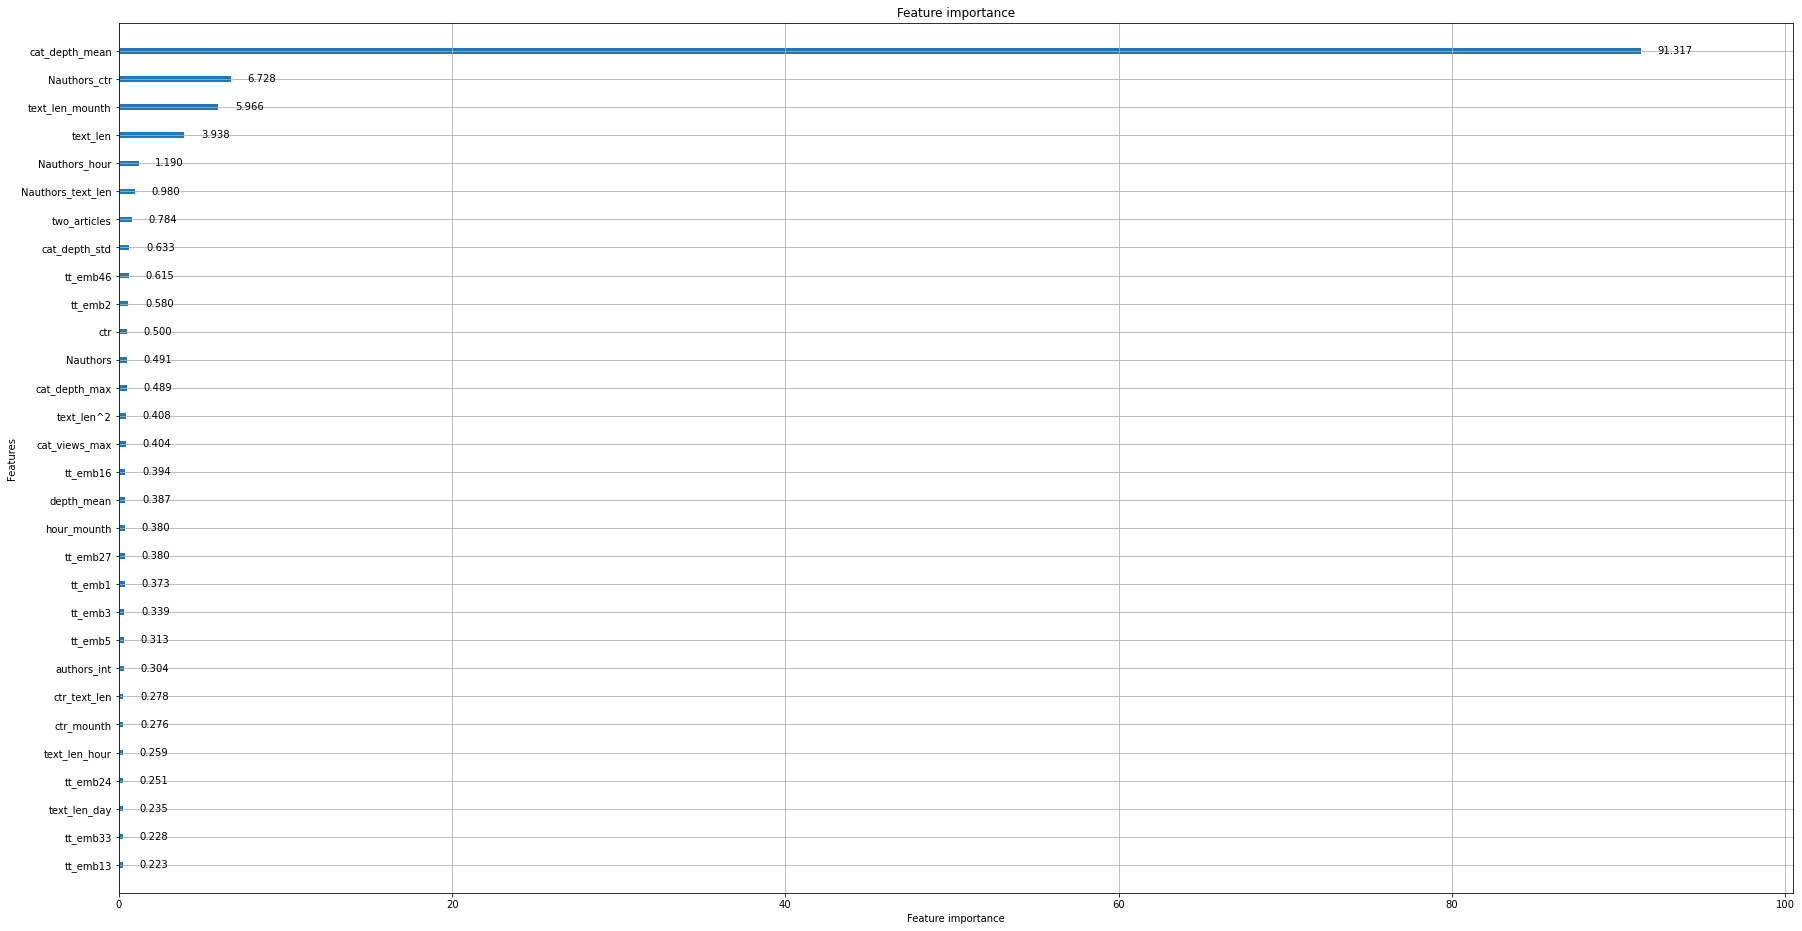

In [31]:
lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [32]:
score_f = lgb.cv(params, 
                 train_frp_full, 
                 #num_boost_round = 10000,
                 num_boost_round=600,
                 nfold = 5,
                 verbose_eval = 500,
                 #early_stopping_rounds = 100,
                 stratified = False,
                 eval_train_metric = r2,
                 feval = r2,
                 #return_cvbooster = True,
                )
print(np.argmin(score_f['valid rmse-mean']), score_f['train rmse-mean'][np.argmin(score_f['valid rmse-mean'])], score_f['train rmse-stdv'][np.argmin(score_f['valid rmse-mean'])], )
print(np.argmin(score_f['valid rmse-mean']), score_f['valid rmse-mean'][np.argmin(score_f['valid rmse-mean'])], score_f['valid rmse-stdv'][np.argmin(score_f['valid rmse-mean'])], )

print(np.argmax(score_f['valid r2-mean']), score_f['train r2-mean'][np.argmax(score_f['valid r2-mean'])], score_f['train r2-stdv'][np.argmax(score_f['valid r2-mean'])], )
print(np.argmax(score_f['valid r2-mean']), score_f['valid r2-mean'][np.argmax(score_f['valid r2-mean'])], score_f['valid r2-stdv'][np.argmax(score_f['valid r2-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.595629 + 0.0175895	cv_agg's train r2: 0.996356 + 0.000237082	cv_agg's valid rmse: 6.59796 + 0.0906078	cv_agg's valid r2: 0.294238 + 0.0360722
92 3.7890842085336507 0.014281677345868478
92 6.554973180673739 0.07693608328575961
581 0.9981768489039016 0.00011000794907566188
581 0.2947943042810161 0.03589005245629661


In [33]:
#if np.argmin(score_f['valid rmse-mean']) != np.argmax(score_f['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_f['valid rmse-mean']), np.argmax(score_f['valid r2-mean']))

In [34]:
#frp_iter = np.argmax(score_f['valid r2-mean'])
frp_iter = np.argmin(score_f['valid rmse-mean'])
print(frp_iter)

92


In [35]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [36]:
# fitting the model
lgb_model_frp = lgb.train(params,
                            train_set=train_frp_full,#train_set=train_ds_frp,
                            #valid_sets=val_ds_frp,
                            num_boost_round = frp_iter,
                            #early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

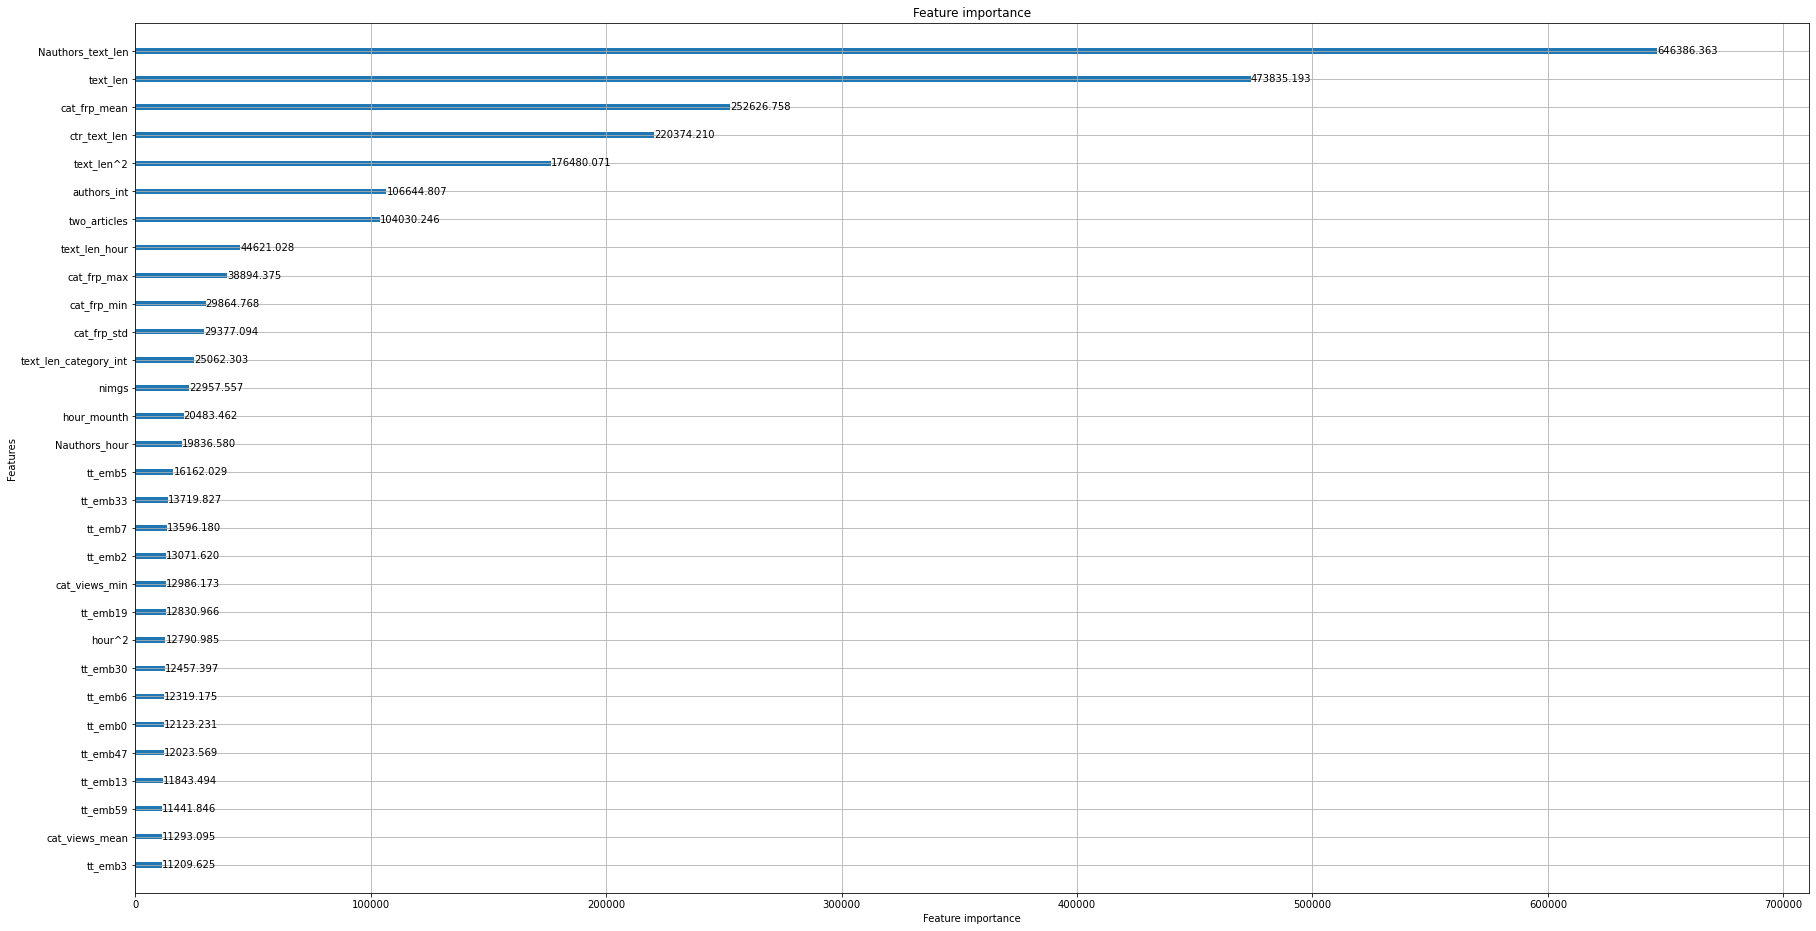

In [37]:
lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

# Сохраняем предсказания для ансамблей / стекинга

## save models

In [38]:
lgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.txt'), num_iteration = lgb_model_views.best_iteration)
lgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.txt'), num_iteration = lgb_model_depth.best_iteration)
lgb_model_frp.save_model(  os.path.join(DIR_MODELS, f'{NAME}_f.txt'),   num_iteration = lgb_model_frp.best_iteration)

## make predict

In [39]:
pred_views = lgb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = lgb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = lgb_model_frp.predict(  df_test[cat_cols + num_cols])

In [40]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [41]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,150933.023632,1.110090,23.778221
1440,327584.387798,1.142594,25.145849
2645,314718.744727,1.175086,25.714627


In [42]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [43]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,13814.777249,1.192477,44.851477
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,9505.274828,1.061550,31.440938
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,9093.847717,1.056075,28.342642
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,7925.973428,1.063515,36.939216
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,102940.275616,1.153002,28.691342


In [44]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)